<a href="https://colab.research.google.com/github/Afonsoleone25/-Treinamento-de-Redes-Neurais-com-Transfer-Learning/blob/main/transfer_learning_malaria_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalação do TensorFlow Datasets (pode ser necessário no Colab)
!pip install tensorflow-datasets

# Importações principais
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os

# Verifica a versão do TF e se a GPU está disponível
print("TensorFlow versão:", tf.__version__)
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

TensorFlow versão: 2.19.0
GPU disponível: []


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.44TCAC_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
Número total de exemplos: 27558
Classes: ['parasitized', 'uninfected']


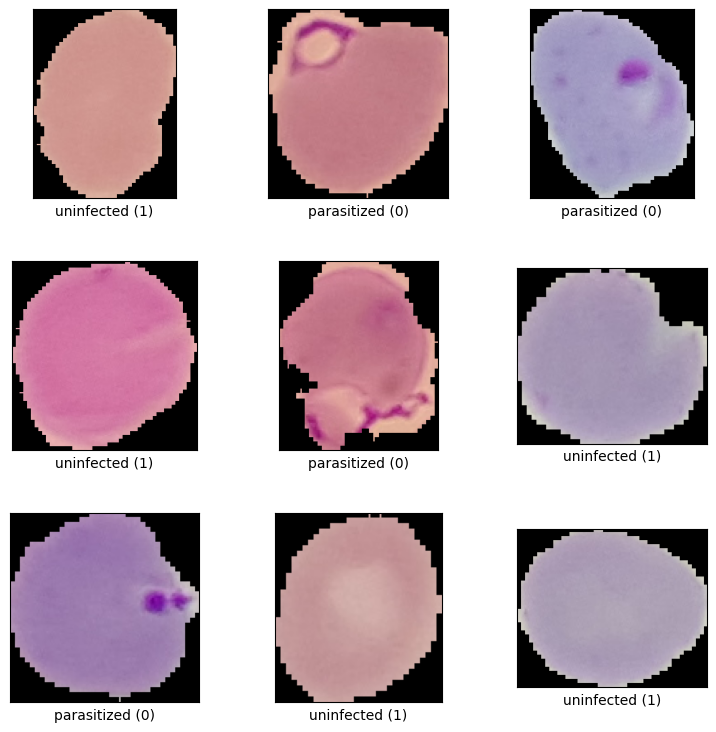

In [3]:
# Carregar o dataset Malaria
(ds_train), ds_info = tfds.load('malaria',
                                 split='train',
                                 shuffle_files=True,
                                 as_supervised=True, # Retorna (imagem, rótulo)
                                 with_info=True) # Inclui metadados

# Explorar informações
print(f"Número total de exemplos: {ds_info.splits['train'].num_examples}")
print(f"Classes: {ds_info.features['label'].names}") # ['parasitized', 'uninfected']

# Visualizar algumas amostras
fig = tfds.show_examples(ds_train.take(9), ds_info)

In [4]:
# Definir proporções (exemplo: 70% treino, 15% validação, 15% teste)
TOTAL_EXEMPLOS = ds_info.splits['train'].num_examples
TAMANHO_TREINO = int(0.7 * TOTAL_EXEMPLOS)
TAMANHO_VAL = int(0.15 * TOTAL_EXEMPLOS)
TAMANHO_TESTE = TOTAL_EXEMPLOS - TAMANHO_TREINO - TAMANHO_VAL

# Embaralhar e dividir o dataset
ds = ds_train.shuffle(buffer_size=10000)
ds_treino = ds.take(TAMANHO_TREINO)
ds_restante = ds.skip(TAMANHO_TREINO)
ds_val = ds_restante.take(TAMANHO_VAL)
ds_teste = ds_restante.skip(TAMANHO_VAL)

print(f"Treino: {tf.data.experimental.cardinality(ds_treino).numpy()}")
print(f"Validação: {tf.data.experimental.cardinality(ds_val).numpy()}")
print(f"Teste: {tf.data.experimental.cardinality(ds_teste).numpy()}")

# Função de pré-processamento
def preparar_imagem(image, label, tamanho_alvo=(224, 224)):
    # Redimensionar para o tamanho esperado pelo modelo base
    image = tf.image.resize(image, tamanho_alvo)
    # Normalizar pixels para o intervalo [0, 1] ou [-1, 1] (depende do modelo)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Aplicar pré-processamento e otimizar o pipeline
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

ds_treino = (ds_treino
             .map(preparar_imagem, num_parallel_calls=AUTOTUNE)
             .batch(BATCH_SIZE)
             .prefetch(AUTOTUNE))
ds_val = (ds_val
          .map(preparar_imagem, num_parallel_calls=AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))
ds_teste = (ds_teste
            .map(preparar_imagem, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

Treino: 19290
Validação: 4133
Teste: 4135


In [5]:
def criar_modelo_transfer_learning():
    # 1. Carregar o modelo base (pré-treinado no ImageNet, sem o topo)
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    # Congelar os pesos do modelo base
    base_model.trainable = False

    # 2. Construir o novo topo do modelo
    inputs = tf.keras.Input(shape=(224, 224, 3))
    # Aplicar o modelo base
    x = base_model(inputs, training=False)
    # Camadas personalizadas
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # Camada de saída para classificação binária
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # 3. Criar o modelo completo
    model = tf.keras.Model(inputs, outputs)

    # 4. Compilar o modelo
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

modelo = criar_modelo_transfer_learning()
modelo.summary() # Visualizar a arquitetura

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Callbacks para melhor controle
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('melhor_modelo_malaria.keras',
                                                monitor='val_accuracy',
                                                save_best_only=True)

# Treinar
historico = modelo.fit(ds_treino,
                       validation_data=ds_val,
                       epochs=10,
                       callbacks=[early_stopping, checkpoint])

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1063s 2s/step - accuracy: 0.8941 - loss: 0.2575 - val_accuracy: 0.9366 - val_loss: 0.1662
Epoch 2/10
297/603 ━━━━━━━━━━━━━━━━━━━━ 6:51 1s/step - accuracy: 0.9348 - loss: 0.1796

In [ ]:
# Avaliar no conjunto de teste
resultado_teste = modelo.evaluate(ds_teste)
print(f"Acurácia no Teste: {resultado_teste[1]*100:.2f}%")
print(f"Loss no Teste: {resultado_teste[0]:.4f}")

# Gerar matriz de confusão (necessário importar sklearn.metrics)
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Coletar todas as previsões e rótulos verdadeiros do conjunto de teste
y_pred = []
y_true = []
for images, labels in ds_teste.unbatch().take(-1):
    pred = modelo.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_pred.append(tf.where(pred > 0.5, 1, 0).numpy()[0][0])
    y_true.append(labels.numpy())

print(classification_report(y_true, y_pred, target_names=['Parasitada', 'Não Infectada']))

# Plotar gráficos de Loss e Acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historico.history['loss'], label='Loss Treino')
plt.plot(historico.history['val_loss'], label='Loss Validação')
plt.title('Loss por Época')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(historico.history['accuracy'], label='Acurácia Treino')
plt.plot(historico.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia por Época')
plt.legend()
plt.tight_layout()
plt.savefig('images/training_history.png')
plt.show()